# Import necessary libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat
from glob import glob
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from itertools import chain
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the aesthetic style of the plots
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')  # Ignore warnings

# Exploratory Data Analysis

## Data Loading

In [2]:
# reading the data
data_entry = pd.read_csv("../data/NIH_Dataset/Data_Entry_2017.csv")
data_entry.head()  # Display the first few rows of the dataset


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
data_entry.shape  # Print the shape of the dataframe

(112120, 12)

In [4]:
data_entry.describe()  # Show the summary statistics

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


## Data Cleaning

In [5]:
# Drop unused columns to focus on relevant data
data_entry = data_entry[['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender']]

# Removing entries where patient age is over 100
total = len(data_entry)
print('No. of rows before removing rows having age >100 : ', len(data_entry))
data_entry = data_entry[data_entry['Patient Age'] < 100]
print('No. of rows after removing rows having age >100 : ', len(data_entry))
print('No. of datapoints having age > 100 : ', total - len(data_entry))

No. of rows before removing rows having age >100 :  112120
No. of rows after removing rows having age >100 :  112104
No. of datapoints having age > 100 :  16


In [6]:
# Count the number of diseases in the 'Finding Labels' for each row
data_entry['Labels_Count'] = data_entry['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)

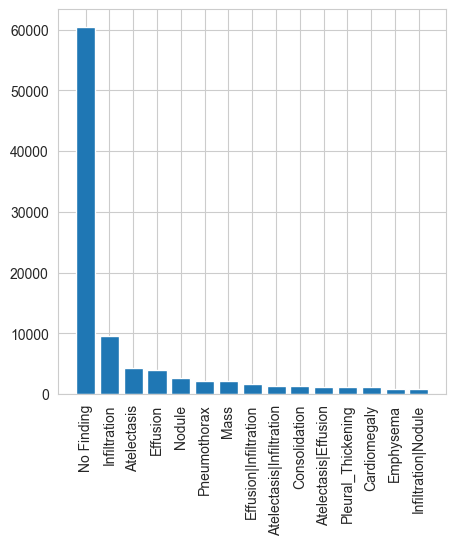

In [7]:
# Visualize the top 15 most common findings
label_counts = data_entry['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))  # Adjusted size to 5x5
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation=90)

## Data Analysis

### Age Distribution by Gender

<Figure size 500x500 with 0 Axes>

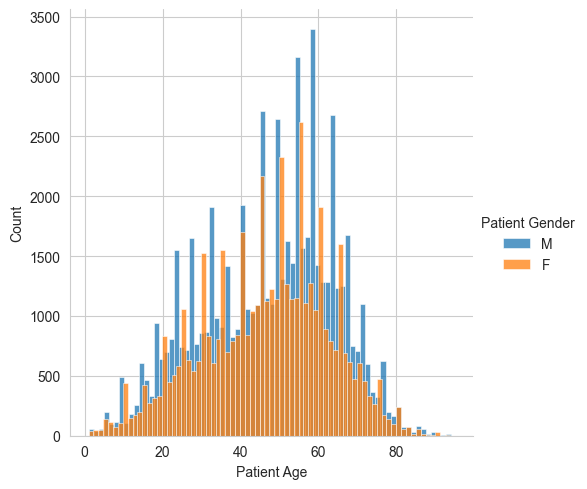

In [8]:
plt.figure(figsize=(5,5))
sns.FacetGrid(data_entry, hue='Patient Gender', height=5).map(sns.histplot, 'Patient Age').add_legend()
plt.show()

### Count of Patient Ages by Gender

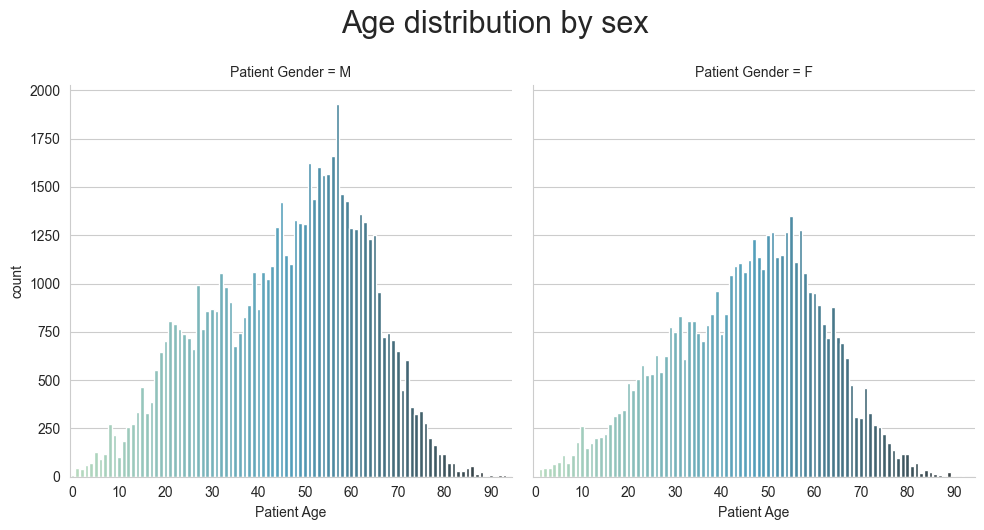

In [9]:
g = sns.catplot(x="Patient Age", col="Patient Gender", data=data_entry, kind="count",
                height=5, aspect=1, palette="GnBu_d")  # Adjusted size to 5x5 and aspect to 1
g.set(xticks=np.arange(0, 100, 10))  # Sets ticks at intervals of 10
g.set_xticklabels(np.arange(0, 100, 10))
g.figure.suptitle('Age distribution by sex', fontsize=22, y=1.05)
g.figure.subplots_adjust(top=0.9)
g.figure.set_size_inches(10, 5)  # Adjusted total size for visibility

### Disease Distribution by Age and Sex

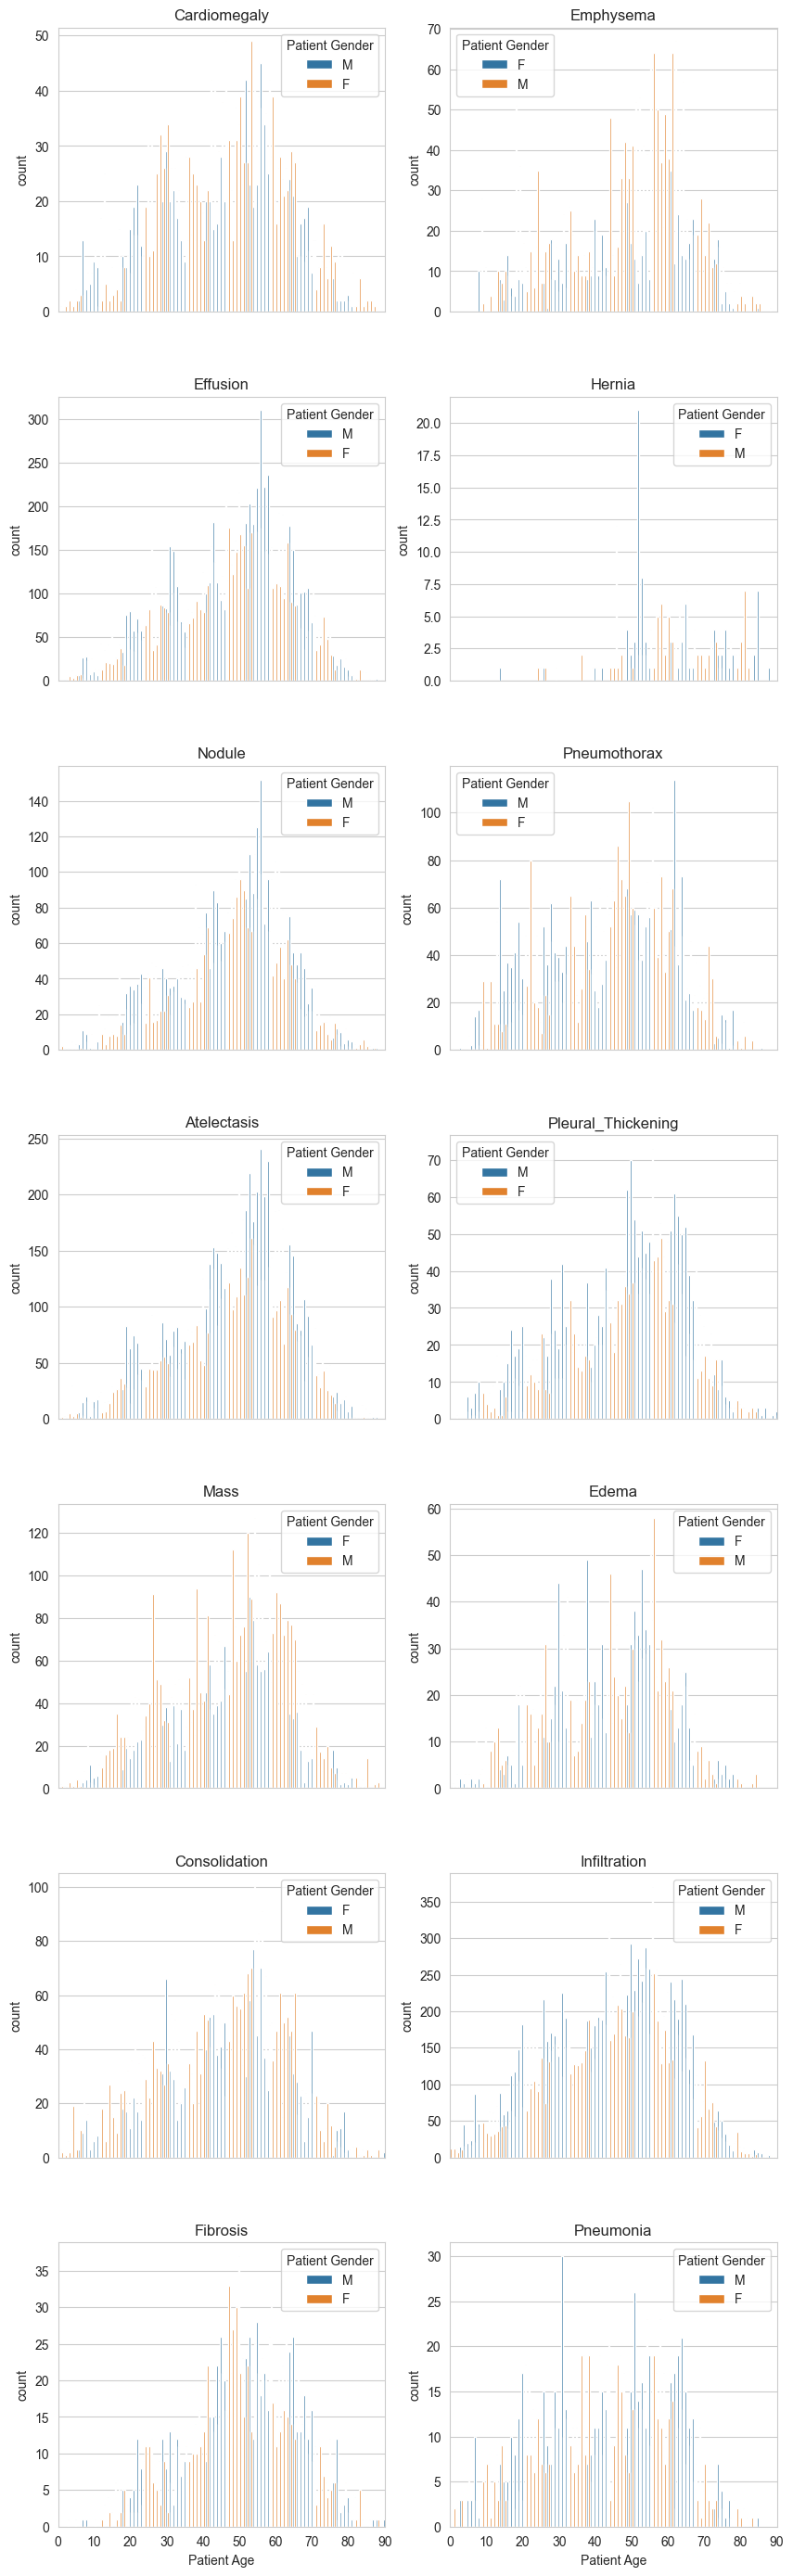

In [10]:
f, axarr = plt.subplots(7, 2, sharex=True, figsize=(10, 35))  # Adjusted each subplot to be taller
pathology_list = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule', 'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass', 'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia']
df = data_entry[data_entry['Finding Labels'] != 'No Finding']
i = 0
j = 0
x = np.arange(0, 100, 10)
for pathology in pathology_list:
    index = [k for k, label in enumerate(df['Finding Labels']) if pathology in label]
    g = sns.countplot(x='Patient Age', hue="Patient Gender", data=df.iloc[index], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)
    g.set_xlim(0, 90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j = (j + 1) % 2
    if j == 0:
        i = (i + 1) % 7
f.subplots_adjust(hspace=0.3)

### No. of each disease by patient gender

In [11]:
for pathology in pathology_list :
    data_entry[pathology] = data_entry['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

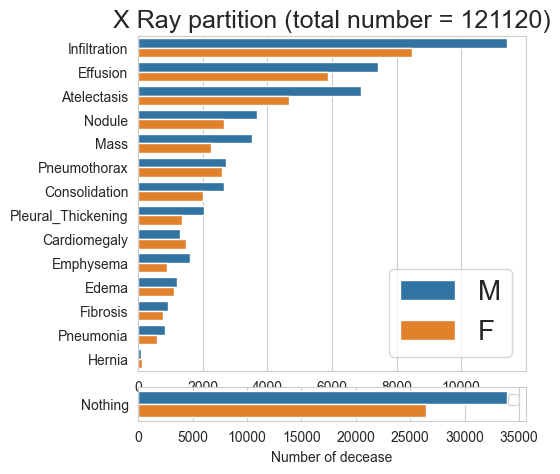

In [12]:
plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(data_entry,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

data_entry['Nothing']=data_entry['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(data_entry,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

### Display patient number by Follow-up in detail

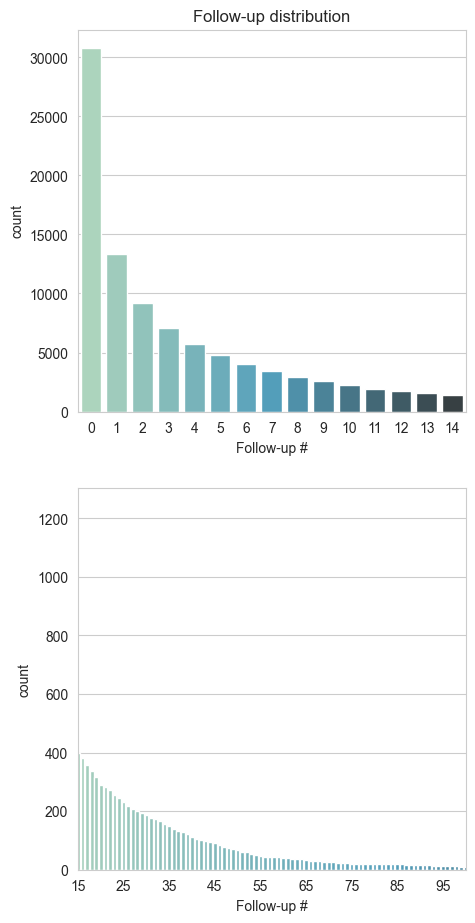

In [13]:
f, (ax1, ax2) = plt.subplots(2, figsize=(5, 10))  # Adjusting subplot size
df = data_entry[data_entry['Follow-up #'] < 15]
sns.countplot(x='Follow-up #', data=df, palette="GnBu_d", ax=ax1)
ax1.set_title('Follow-up distribution')
df = data_entry[data_entry['Follow-up #'] > 14]
sns.countplot(x='Follow-up #', data=df, palette="GnBu_d", ax=ax2)
ax2.set_xlim(15, 100)
ax2.set_xticks(np.arange(15, 100, 10))
ax2.set_xticklabels(np.arange(15, 100, 10))
f.subplots_adjust(top=0.95)
plt.show()

### ratio between one and multiple disease

In [14]:
df=data_entry.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

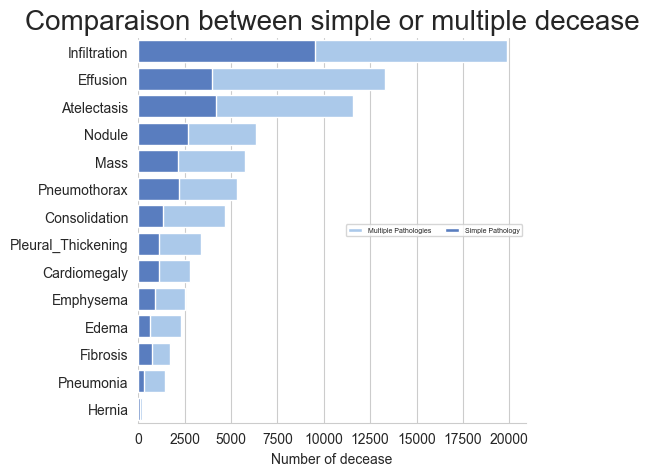

In [15]:
f, ax = plt.subplots(sharex=True,figsize=(5, 5))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=5)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)      
sns.despine(left=True)

### Plot most important pathologies groups for each desease

In [16]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

,Patient ID,Finding Labels,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
Finding Labels,,,,,,,,,,,,,,,,
Effusion|Infiltration,1603,Effusion|Infiltration,0,0,1603,0,0,0,0,0,0,0,0,1603,0,0
Atelectasis|Infiltration,1350,Atelectasis|Infiltration,0,0,0,0,0,0,1350,0,0,0,0,1350,0,0
Atelectasis|Effusion,1165,Atelectasis|Effusion,0,0,1165,0,0,0,1165,0,0,0,0,0,0,0
Infiltration|Nodule,829,Infiltration|Nodule,0,0,0,0,829,0,0,0,0,0,0,829,0,0
Atelectasis|Effusion|Infiltration,737,Atelectasis|Effusion|Infiltration,0,0,737,0,0,0,737,0,0,0,0,737,0,0
Cardiomegaly|Effusion,484,Cardiomegaly|Effusion,484,0,484,0,0,0,0,0,0,0,0,0,0,0
Consolidation|Infiltration,441,Consolidation|Infiltration,0,0,0,0,0,0,0,0,0,0,441,441,0,0
Infiltration|Mass,418,Infiltration|Mass,0,0,0,0,0,0,0,0,418,0,0,418,0,0
Effusion|Pneumothorax,403,Effusion|Pneumothorax,0,0,403,0,0,403,0,0,0,0,0,0,0,0


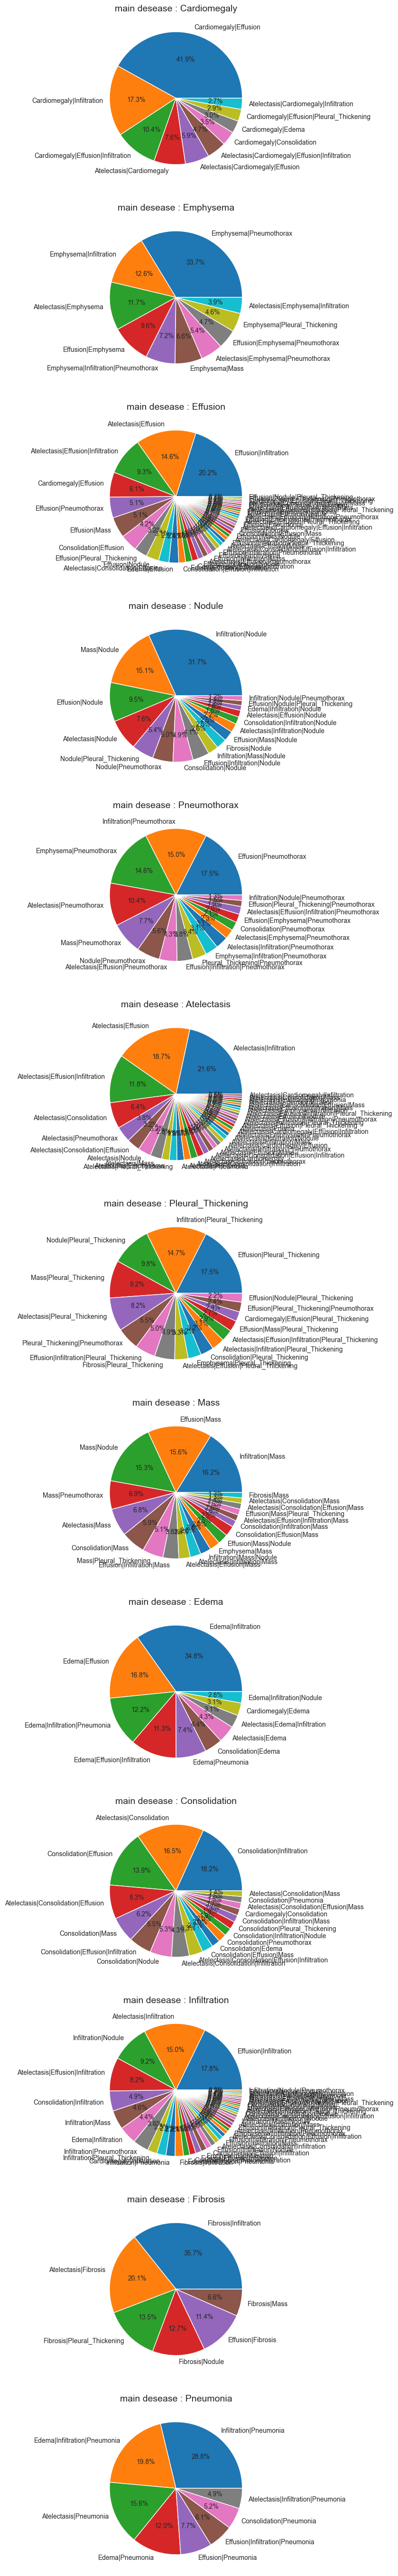

In [17]:
#'Hernia' has not enough values to figure here
df4=df3[df3['Hernia']>0]  # df4.size == 0
#remove 'Hernia' from list
pat_list=[elem for elem in pathology_list if 'Hernia' not in elem]

f, axarr = plt.subplots(13, sharex=True,figsize=(5, 70))
i=0
for pathology in pat_list :
    df4=df3[df3[pathology]>0]
    if df4.size>0:  #'Hernia' has not enough values to figure here
        axarr[i].pie(df4[pathology],labels=df4['Finding Labels'], autopct='%1.1f%%')
        axarr[i].set_title('main desease : '+pathology,fontsize=14)   
        i +=1

# Creating data for model

In [18]:
# Load initial data
data = pd.read_csv('../data/NIH_Dataset/Data_Entry_2017.csv')

# Filter out data entries where Patient Age is greater than 99
data = data[data['Patient Age'] < 100]

# Define the base directory path where images are stored
base_path = '../data/NIH_Dataset'

# Use glob to find all PNG images in the nested directories and map them by their basename
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join(base_path, 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', data.shape[0])

# Map image paths to the data entries
data['path'] = data['Image Index'].map(all_image_paths.get)

# Ensure the 'Patient Age' is an integer value
data['Patient Age'] = data['Patient Age'].apply(lambda x: int(x[:-1]) if isinstance(x, str) and not x[-1].isdigit() else int(x))

data.sample(5)

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
32122,00008399_000.png,No Finding,0,8399,41,F,PA,2048,2500,0.168,0.168,NaN,../data/NIH_Dataset\images_004\images\00008399...
39766,00010384_020.png,Atelectasis|Consolidation,20,10384,17,F,AP,2500,2048,0.168,0.168,NaN,../data/NIH_Dataset\images_005\images\00010384...
101980,00027132_000.png,No Finding,0,27132,69,M,PA,3056,2544,0.139,0.139,NaN,../data/NIH_Dataset\images_011\images\00027132...
25542,00006714_005.png,No Finding,5,6714,28,F,AP,2500,2048,0.171,0.171,NaN,../data/NIH_Dataset\images_004\images\00006714...
100188,00026547_000.png,No Finding,0,26547,50,M,PA,2754,2897,0.143,0.143,NaN,../data/NIH_Dataset\images_011\images\00026547...


In [19]:
# Normalize the 'Finding Labels' field by removing 'No Finding'
data['Finding Labels'] = data['Finding Labels'].replace('No Finding', '')

# Extract unique labels from the 'Finding Labels' field
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if x]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# Create binary columns for each label
for c_label in all_labels:
    if len(c_label) > 1:
        data[c_label] = data['Finding Labels'].apply(lambda finding: 1.0 if c_label in finding else 0)

data.sample(5)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20118,00005373_001.png,,1,5373,33,F,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60902,00015034_002.png,,2,15034,65,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29629,00007716_002.png,Mass,2,7716,34,F,AP,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
37459,00009875_005.png,Infiltration,5,9875,18,F,PA,2754,2577,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
40379,00010514_000.png,,0,10514,35,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Filter labels to keep only those that appear in at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum() > MIN_CASES]
print('Clean Labels ({}):'.format(len(all_labels)), [(c_label, int(data[c_label].sum())) for c_label in all_labels])

Clean Labels (13): [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


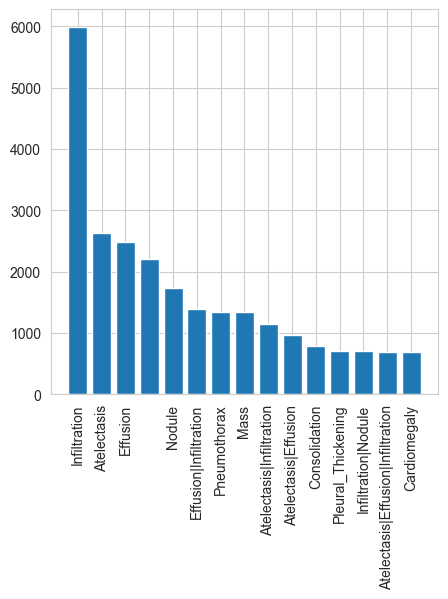

In [21]:
# Calculate sample weights based on the number of diseases diagnosed
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if x else 0).values + 0.04
sample_weights /= sample_weights.sum()

# Sample the data based on the computed weights to create a balanced dataset
data = data.sample(40000, weights=sample_weights)

# Visualize the distribution of findings
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
ax1.set_xticklabels(label_counts.index, rotation=90)
plt.show()

In [22]:
# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
data.iloc[0]['disease_vec']

array([1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)